In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# DEBUG
print(IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

True
Mounted at /content/drive


In [2]:

import os
import random
import time
import platform

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
import torch.nn.functional as F
from torch import nn, optim
# import torch.nn as nn
# import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import transforms, models, datasets, utils
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 135MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))



Device: cuda


In [5]:
!nvidia-smi

Fri Dec  1 04:55:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
ds_path = '/content/drive/My Drive/archive/Plants_2/'

In [7]:
# Número de classes
num_classes = 22

# Nomes das classes
class_names = [
    'Alstonia Scholaris diseased (P2a)',
    'Alstonia Scholaris healthy (P2b)',
    'Arjun diseased (P1a)',
    'Arjun healthy (P1b)',
    'Bael diseased (P4b)',
    'Basil healthy (P8)',
    'Chinar diseased (P11b)',
    'Chinar healthy (P11a)',
    'Gauva diseased (P3b)',
    'Gauva healthy (P3a)',
    'Jamun diseased (P5b)',
    'Jamun healthy (P5a)',
    'Jatropha diseased (P6b)',
    'Jatropha healthy (P6a)',
    'Lemon diseased (P10b)',
    'Lemon healthy (P10a)',
    'Mango diseased (P0b)',
    'Mango healthy (P0a)',
    'Pomegranate diseased (P9b)',
    'Pomegranate healthy (P9a)',
    'Pongamia Pinnata diseased (P7b)',
    'Pongamia Pinnata healthy (P7a)'
    ]

# Tamanho do lote (mini-batch)
batch_size = 64

# Taxa de aprendizado
lr = 0.001

# Mommentum
mm = 0.9

# Número de épocas
epochs = 25 # Usar durante o desenvolvimento
### epochs = 50

In [8]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    ### transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    # Média e desvio padrão do ImageNet.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dataset = datasets.ImageFolder(root= ds_path + "train", transform=data_transforms)
test_dataset = datasets.ImageFolder(root=ds_path + "test", transform=data_transforms)
val_dataset = datasets.ImageFolder(root=ds_path + "valid", transform=data_transforms)


# Embaralhar o conjunto de treinamento
num_train_samples = len(train_dataset)
indices = list(range(num_train_samples))
random.shuffle(indices)

quarter_size = int(0.25 * num_train_samples)
selected_indices = indices[:quarter_size]

# Criar um novo conjunto de treinamento com apenas 25% das imagens
subset_train_dataset = torch.utils.data.Subset(train_dataset, selected_indices)
# train_size = len(train_dataset)
test_size = len(test_dataset)
val_size = len(val_dataset)
train_size = len(subset_train_dataset)

# DEBUG
print(train_size)
print(test_size)
print(val_size)

train_dataloader = torch.utils.data.DataLoader(dataset=subset_train_dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size)

1068
110
110


In [9]:
def show_transformed_image(image):
    # Unnormalize all channels
    ### for t, m, s in zip(np_image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): # (ImageNet weights)
        t.mul_(s).add_(m)

    np_image = image.numpy()

    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

# Visualizar 'batch_size' imagens
dataloader_vis = torch.utils.data.DataLoader(dataset=train_dataloader, shuffle=True, batch_size=64)
items = iter(dataloader_vis)
for image, label in items:
    pass

show_transformed_image(utils.make_grid(image))

TypeError: ignored

In [10]:
### model_ft = models.alexnet(pretrained=True)
model_ft = models.alexnet(weights='AlexNet_Weights.DEFAULT')

# Altera o número de neurônios na cadama de saída.
model_ft.classifier[6] = nn.Linear(4096, num_classes)

In [11]:
# Simple net
### model = Net(3, 5)

# Pretrainned
model = model_ft

In [12]:
# Envia o modelo para a GPU
if DEVICE.type == 'cuda':
    model = model.cuda() # Cuda

# Imprime o modelo
print(str(model))

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
# Função de perda
criterion = nn.CrossEntropyLoss()

# Otimizador
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)

In [14]:
def get_subset():
  num_train_samples = len(train_dataset)
  indices = list(range(num_train_samples))
  random.shuffle(indices)

  quarter_size = int(0.25 * num_train_samples)
  selected_indices = indices[:quarter_size]

  # Criar um novo conjunto de treinamento com apenas 25% das imagens
  subset_train_dataset = torch.utils.data.Subset(train_dataset, selected_indices)

  return torch.utils.data.DataLoader(dataset=subset_train_dataset, batch_size=batch_size)

In [15]:
# Tempo total do treinamento (treinamento e validação)
time_total_start = time.time()

# Lista das perdas (loss) e acurácias (accuracy) de trino para cada época.
train_loss_list = []
train_acc_list = []

# Lista das perdas (loss) e acurácias (accuracy) de validação para cada época.
val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
    # TREINAMENTO
    # =========================================================================

    train_dataloader = get_subset()

    # Inicia contagem de tempo da época
    time_epoch_start = time.time()

    # Habilita o modelo para o modo de treino
    model_ft.train()

    # Perda (loss) nesta época
    loss_epoch_train = 0.0
    # Amostras classificadas corretamente nesta época
    num_hits_epoch_train = 0

    # Iterate along the batches of the TRAINING SET
    for inputs, labels in train_dataloader:
        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad()

        # FORWARD
        # ------>
        # Habilita o cálculo do gradiente
        torch.set_grad_enabled(True)

        # Saída do modelo para o lote
        outputs = model_ft(inputs)

        # 'outputs' está em porcentagens. Tomar os maximos como resposta.
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # BACKWARD
        # <-------
        loss.backward()

        # Atualiza os parâmetros da rede
        optimizer.step()

        # Atualiza a perda da época
        loss_epoch_train += float(loss.item()) * inputs.size(0)

        # Atualiza o número de amostras classificadas corretamente na época.
        num_hits_epoch_train += torch.sum(preds == labels.data)

    # Perda desta época
    train_loss = loss_epoch_train / train_size
    # Acurácia desta época
    train_acc = float(num_hits_epoch_train.double() / train_size)

    # Store loss and accuracy in lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # VALIDAÇÃO
    # =========================================================================
    model_ft.eval()

    # Pego o numero de perda e o numero de acertos
    loss_epoch_val = 0.0 # Atual perda
    num_hits_epoch_val = 0 # Numero de itens corretos

    # Iterate along the batches of the VALIDATION SET
    for inputs, labels in val_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad()

        # Desabilita o cálculo do gradiente durante a validação.
        torch.set_grad_enabled(False)

        # Gero um tensor cujas linhas representam o tamanho do "batch" do input
        outputs = model_ft(inputs)

        # Retorna a maior predicao.
        #### _, preds = torch.max(outputs, 1)
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # Atualiza a perda da época
        loss_epoch_val += float(loss.item()) * inputs.size(0)
        # # Atualiza os acertos da época
        num_hits_epoch_val += torch.sum(preds == labels.data)

    # Ajusta o learning rate
    ### scheduler.step()

    # Perda e acuracia do conjunto de validacao para esta época
    val_loss = loss_epoch_val / val_size
    val_acc = float(num_hits_epoch_val.double() / val_size)

    # Store loss and accuracy in lists
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Tempo total desta época
    time_epoch = time.time() - time_epoch_start

    # PRINTING
    # --------
    print('Epoch {}/{} - TRAIN Loss: {:.4f} TRAIN Acc: {:.4f} - VAL. Loss: {:.4f} VAL. Acc: {:.4f} ({:.4f} seconds)'.format(epoch, epochs - 1, train_loss, train_acc, val_loss, val_acc, time_epoch))

# Tempo total do treinamento
time_total_train = time.time() - time_total_start

# PRINTING
print('\nTreinamento finalizado. ({0}m and {1}s)'.format(int(time_total_train // 60), int(time_total_train % 60)))

Epoch 0/24 - TRAIN Loss: 2.5223 TRAIN Acc: 0.2463 - VAL. Loss: 2.0321 VAL. Acc: 0.4000 (846.9855 seconds)
Epoch 1/24 - TRAIN Loss: 1.3237 TRAIN Acc: 0.5936 - VAL. Loss: 1.0187 VAL. Acc: 0.6545 (659.3413 seconds)
Epoch 2/24 - TRAIN Loss: 0.7843 TRAIN Acc: 0.7378 - VAL. Loss: 0.8701 VAL. Acc: 0.7273 (593.7174 seconds)
Epoch 3/24 - TRAIN Loss: 0.5503 TRAIN Acc: 0.8174 - VAL. Loss: 0.8629 VAL. Acc: 0.6909 (523.3466 seconds)
Epoch 4/24 - TRAIN Loss: 0.5560 TRAIN Acc: 0.7996 - VAL. Loss: 0.7579 VAL. Acc: 0.6909 (480.7114 seconds)
Epoch 5/24 - TRAIN Loss: 0.4333 TRAIN Acc: 0.8558 - VAL. Loss: 0.7448 VAL. Acc: 0.7364 (435.1331 seconds)
Epoch 6/24 - TRAIN Loss: 0.3681 TRAIN Acc: 0.8792 - VAL. Loss: 0.7684 VAL. Acc: 0.7727 (409.0146 seconds)
Epoch 7/24 - TRAIN Loss: 0.3665 TRAIN Acc: 0.8689 - VAL. Loss: 0.7762 VAL. Acc: 0.7636 (392.2791 seconds)
Epoch 8/24 - TRAIN Loss: 0.3537 TRAIN Acc: 0.8773 - VAL. Loss: 0.5527 VAL. Acc: 0.7727 (363.3006 seconds)
Epoch 9/24 - TRAIN Loss: 0.3093 TRAIN Acc: 0.8

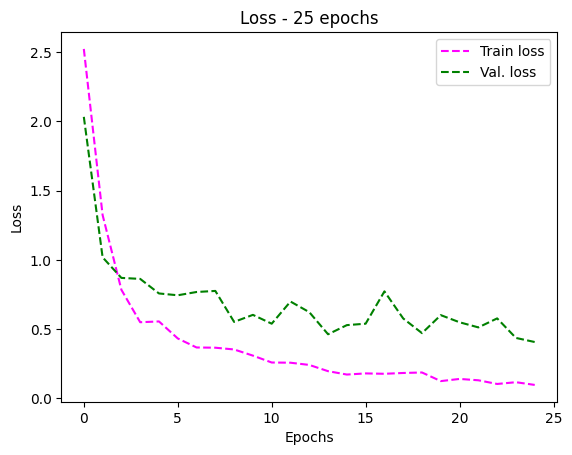

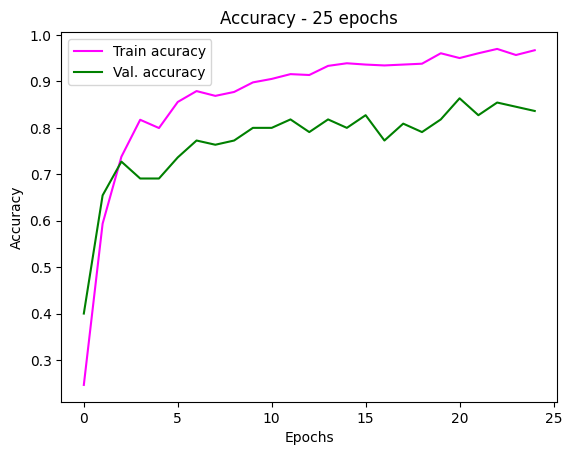

In [16]:
# Lista com os indices das épocas. [0, 1, ... num_epochs - 1]
epochs_list = []
for i in range(len(train_loss_list)):
    epochs_list.append(i)

# Titulo - Loss and accuracy chart
loss_title = 'Loss - ' + str(epochs) + ' epochs'
acc_title = 'Accuracy - ' + str(epochs) + ' epochs'

# Plot - Loss
plt.figure()
plt.title(loss_title)
plt.plot(epochs_list, train_loss_list, c='magenta' ,ls='--', label='Train loss', fillstyle='none')
plt.plot(epochs_list, val_loss_list, c='green' ,ls='--', label='Val. loss', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

# Plot - Accuracy
plt.figure()
plt.title(acc_title)
plt.plot(epochs_list, train_acc_list, c='magenta' ,ls='-', label='Train acuracy', fillstyle='none')
plt.plot(epochs_list, val_acc_list, c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

In [17]:
# Lista com as classes reais e classes preditas
true_val_list = []
pred_val_list = []
# Lista com as probabilidades
prob_val_list = []

# Iterate along the batches of the VALIDATION SET
for i, (img_list, labelList) in enumerate(val_dataloader):

    if DEVICE.type == 'cuda':
        img_list = img_list.to(DEVICE)
        labelList = labelList.to(DEVICE)

    # Desabilita o cálculo do gradiente durante validação e testes.
    torch.set_grad_enabled(False)

    # -----> FORWARD
    # Saída do modelo
    outputs = model_ft(img_list)

    # Predição
    ### _, preds = torch.max(output, 1)
    preds = torch.argmax(outputs, dim=1)

    # Calcula probabilidades
    # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
    outputs_prob = nn.functional.softmax(outputs, dim=1)
    prob_val_batch = np.asarray(outputs_prob.cpu())

    # Classes reais true) e classes preditas (pred) para este lote.
    if DEVICE.type == 'cuda':
        true_val_batch = np.asarray(labelList.cpu())
        pred_val_batch = np.asarray(preds.cpu())

    # Itera ao longo do lote
    for i in range(0, len(pred_val_batch)):
        true_val_list.append(true_val_batch[i])
        pred_val_list.append(pred_val_batch[i])

        prob_val_list.append(prob_val_batch[i])

In [18]:
# Confusion matrix
conf_mat_val = metrics.confusion_matrix(true_val_list, pred_val_list)
print('\nConfusion matrix ( validation)')
print(conf_mat_val)

# Classification report - Scikit-learn
class_rep_val = metrics.classification_report(true_val_list, pred_val_list,
                                              target_names=class_names, digits=4,
                                              zero_division=0)
print('\nClass. report (validation)')
print(class_rep_val)

# Accuracy
acc_val = metrics.accuracy_score(true_val_list, pred_val_list)
print('\n\nValidation Acc.: {:.4f}'.format(acc_val))


Confusion matrix ( validation)
[[4 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 0 0 